Epoch 1/500
14/14 - 2s - loss: 0.2004 - 2s/epoch - 125ms/step
Epoch 2/500
14/14 - 0s - loss: 0.0215 - 40ms/epoch - 3ms/step
Epoch 3/500
14/14 - 0s - loss: 0.0106 - 29ms/epoch - 2ms/step
Epoch 4/500
14/14 - 0s - loss: 0.0060 - 37ms/epoch - 3ms/step
Epoch 5/500
14/14 - 0s - loss: 0.0040 - 31ms/epoch - 2ms/step
Epoch 6/500
14/14 - 0s - loss: 0.0036 - 32ms/epoch - 2ms/step
Epoch 7/500
14/14 - 0s - loss: 0.0033 - 34ms/epoch - 2ms/step
Epoch 8/500
14/14 - 0s - loss: 0.0031 - 33ms/epoch - 2ms/step
Epoch 9/500
14/14 - 0s - loss: 0.0032 - 33ms/epoch - 2ms/step
Epoch 10/500
14/14 - 0s - loss: 0.0028 - 37ms/epoch - 3ms/step
Epoch 11/500
14/14 - 0s - loss: 0.0025 - 33ms/epoch - 2ms/step
Epoch 12/500
14/14 - 0s - loss: 0.0023 - 35ms/epoch - 2ms/step
Epoch 13/500
14/14 - 0s - loss: 0.0022 - 32ms/epoch - 2ms/step
Epoch 14/500
14/14 - 0s - loss: 0.0020 - 30ms/epoch - 2ms/step
Epoch 15/500
14/14 - 0s - loss: 0.0019 - 32ms/epoch - 2ms/step
Epoch 16/500
14/14 - 0s - loss: 0.0018 - 41ms/epoch - 3ms/step
E

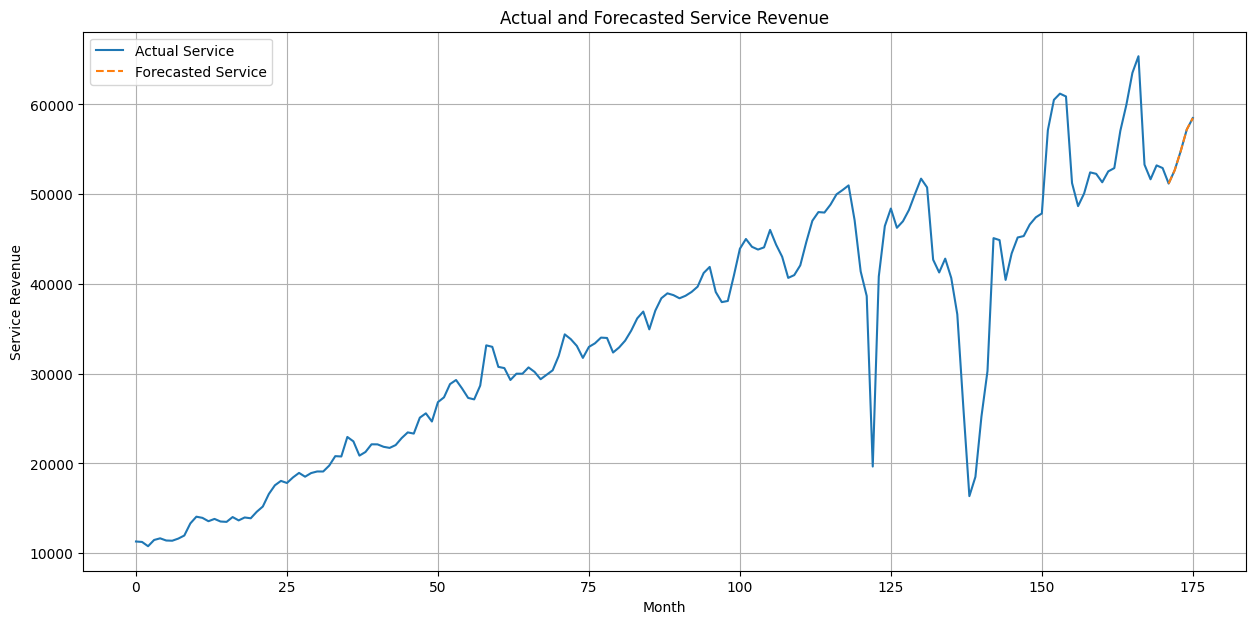

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
import time
import matplotlib.pyplot as plt

# Đọc dữ liệu từ tệp CSV
df = pd.read_csv('Dataa_Service.csv')

# Tạo các đặc trưng trễ (lagged features)
def create_lagged_features(data, lag=3):
    df_lagged = data.copy()
    for i in range(1, lag + 1):
        df_lagged[f'Service_lag_{i}'] = df_lagged['Service'].shift(i)
    df_lagged.dropna(inplace=True)
    return df_lagged

lag = 3
df_lagged = create_lagged_features(df, lag)

# Chọn các cột đầu vào và đầu ra
X = df_lagged[['Month', 'Year', 'CPI', 'GDP', 'Temperature', 'USD/VND'] + [f'Service_lag_{i}' for i in range(1, lag + 1)]]
y = df_lagged['Service']

# Chuẩn hóa dữ liệu
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Xây dựng mô hình mạng nơron
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Biên dịch mô hình
model.compile(loss='mean_squared_error', optimizer='adam')

# Đo thời gian bắt đầu huấn luyện
start_time = time.time()

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=500, batch_size=10, verbose=2)

# Đo thời gian kết thúc huấn luyện
end_time = time.time()

# Dự báo trên tập kiểm tra
y_pred_scaled = model.predict(X_test)

# Chuyển đổi lại dữ liệu về dạng ban đầu
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test)

# Tính toán các chỉ số đánh giá
mse = np.mean((y_pred - y_test) ** 2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
adjusted_r2 = 1 - (1 - r2) * ((len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))

# In các chỉ số đánh giá
print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE: {mae:.2f}')
print(f'Test R^2: {r2:.2f}')
print(f'Test MAPE: {mape:.2f}')
print(f'Test Adjusted R^2: {adjusted_r2:.2f}')

# Dự báo cho 5 tháng tiếp theo với cửa sổ trượt
last_known_data = df_lagged.iloc[-lag:][['Month', 'Year', 'CPI', 'GDP', 'Temperature', 'USD/VND'] + [f'Service_lag_{i}' for i in range(1, lag + 1)]].copy()
last_known_service = df_lagged['Service'].iloc[-lag:].values

predictions = []

for i in range(5):
    # Tạo dữ liệu đầu vào cho dự báo tiếp theo
    next_month = last_known_data['Month'].iloc[-1] + 1
    next_year = last_known_data['Year'].iloc[-1]
    if next_month > 12:
        next_month = 1
        next_year += 1

    # Sử dụng giá trị trung bình cho các cột không thay đổi
    next_data = {
        'Month': next_month,
        'Year': next_year,
        'CPI': X['CPI'].mean(),
        'GDP': X['GDP'].mean(),
        'Temperature': X['Temperature'].mean(),
        'USD/VND': X['USD/VND'].mean()
    }

    for lag in range(1, lag + 1):
        next_data[f'Service_lag_{lag}'] = last_known_service[-lag]

    next_df = pd.DataFrame([next_data])
    next_scaled = scaler_X.transform(next_df)
    next_pred_scaled = model.predict(next_scaled)
    next_pred = scaler_y.inverse_transform(next_pred_scaled)

    # Cập nhật dữ liệu với giá trị dự báo mới
    next_data['Service'] = next_pred[0][0]
    predictions.append(next_data)

    # Cập nhật last_known_data và last_known_service
    next_service_lags = [next_data['Service']] + [last_known_service[-i] for i in range(1, lag)]
    last_known_service = np.array(next_service_lags)
    next_df['Service'] = next_pred[0][0]
    last_known_data = pd.concat([last_known_data, next_df], ignore_index=True)

# In kết quả dự báo
predictions_df = pd.DataFrame(predictions)

# In dự báo
print(predictions_df[['Month', 'Year', 'Service']])

# Kết hợp dữ liệu thực tế và dữ liệu dự báo
combined_df = pd.concat([df, predictions_df[['Month', 'Year', 'Service']]], ignore_index=True)

# Vẽ biểu đồ
plt.figure(figsize=(15, 7))
plt.plot(combined_df.index, combined_df['Service'], label='Actual Service')
plt.plot(range(len(df), len(df) + len(predictions_df)), predictions_df['Service'], label='Forecasted Service', linestyle='dashed')
plt.xlabel('Month')
plt.ylabel('Service Revenue')
plt.title('Actual and Forecasted Service Revenue')
plt.legend()
plt.grid(True)
plt.show()
